# Question Answering


This notebook was inspired by the Neural Machine Translation assignment from the Andrew Ng's Deep Learning Specialization on Coursera. 



In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 - Dataset

We Load a dataset consisting of 2002 pairs (question, one word answer)

In [2]:

df = pd.read_csv('data/dataset.csv') 


In [3]:
df.head()

,Question,Answer
0,was volta an italian physicist,yes
1,is volta buried in the city of pittsburgh,no
2,did volta have a passion for the study of elec...,yes
3,is it a disadvantage for something to be unsaf...,yes
4,was lombardy under napoleons rule in 1800,yes


In [4]:
dataset = [tuple(x) for x in df.to_records(index=False)]

In [5]:
dataset[:3]

[('was volta an italian physicist', 'yes'),
 ('is volta buried in the city of pittsburgh', 'no'),
 ('did volta have a passion for the study of electricity', 'yes')]

In [6]:
question_list = df['Question'].to_list()
splitted_list = [q.split(' ') for q in question_list]
flat_list = [item for sublist in splitted_list for item in sublist if len(item) > 0]
flat_list = list(set(flat_list))
human_vocab = dict(zip(sorted(flat_list) + ['<unk>', '<pad>'], 
                     list(range(len(flat_list) + 2))))


In [7]:
answer_list = df['Answer'].to_list()
splitted_list_a = [q.split(' ') for q in answer_list]
flat_list_a = [item for sublist in splitted_list_a for item in sublist if len(item) > 0]
flat_list_a = list(set(flat_list_a))
machine_vocab = dict(zip(sorted(flat_list_a), 
                     list(range(len(flat_list_a)))))
inv_machine_vocab = {v: k for k, v in machine_vocab.items()}
machine_vocab


{'no': 0, 'perhaps': 1, 'what': 2, 'yes': 3}

In [8]:
m = len(df)

In [9]:

def string_to_int(string, length, vocab):
    """
    Converts all strings in the vocabulary into a list of integers representing the positions of the
    input string's characters in the "vocab"
    
    Arguments:
    string -- input string, e.g. 'Wed 10 Jul 2007'
    length -- the number of time steps you'd like, determines if the output will be padded or cut
    vocab -- vocabulary, dictionary used to index every character of your "string"
    
    Returns:
    rep -- list of integers (or '<unk>') (size = length) representing the position of the string's character in the vocabulary
    """
    
    #make lower to standardize
    string = string.lower()
    string = string.replace(',','')
    string = string.split() #bagat de mine
    
    if len(string) > length:
        string = string[:length]
        
    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
    
    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))
    
    #print (rep)
    return rep


def int_to_string(ints, inv_vocab):
    """
    Output a machine readable list of characters based on a list of indexes in the machine's vocabulary
    
    Arguments:
    ints -- list of integers representing indexes in the machine's vocabulary
    inv_vocab -- dictionary mapping machine readable indexes to machine readable characters 
    
    Returns:
    l -- list of characters corresponding to the indexes of ints thanks to the inv_vocab mapping
    """
    
    l = [inv_vocab[i] for i in ints]
    return l

In [10]:
Tx = 10
Ty = 1
X, Y = zip(*dataset)
    
X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
Y = np.array([string_to_int(t, Ty, machine_vocab) for t in Y])
    


In [11]:

human_vocab['<unk>']

5154

In [12]:
X

array([[4948, 4915,  342, ..., 5155, 5155, 5155],
       [2462, 4915,  743, ..., 3512, 5155, 5155],
       [1391, 4915, 2175, ..., 4414, 3258, 1571],
       ...,
       [2462, 2475, 4735, ..., 3988, 3984, 3546],
       [4998,  189,  252, ..., 5155, 5155, 5155],
       [ 391, 3196, 3194, ..., 2169,  180, 3196]])

In [13]:
Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))


In [14]:
Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))

In [15]:


print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (2002, 10)
Y.shape: (2002, 1)
Xoh.shape: (2002, 10, 5156)
Yoh.shape: (2002, 1, 4)


In [16]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: was volta an italian physicist
Target date: yes

Source after preprocessing (indices): [4948 4915  342 2476 3484 5155 5155 5155 5155 5155]
Target after preprocessing (indices): [3]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 0. 1.]]


In [17]:

def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = tf.keras.backend.ndim(x)
    if ndim == 2:
        return tf.keras.backend.softmax(x)
    elif ndim > 2:
        e = tf.exp(x - tf.keras.backend.max(x, axis=axis, keepdims=True))
        s = tf.keras.backend.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')
        

In [18]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1)

We use the attention mechanism from Andrew Ng's neural machine translation

In [19]:

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    s_prev = repeator(s_prev)
    concat = concatenator([a,s_prev])
    e = densor1(concat)
    energies = densor2(e)
    alphas = activator(energies)
    context = dotor([alphas,a])
    
    return context

In [20]:
n_a = 4 
n_s = 8 
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

In [21]:


def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    X = Input(shape=(Tx, human_vocab_size), name= 'X')
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []  
    a = Bidirectional(LSTM(n_a,return_sequences=True))(X)  
    for t in range(Ty):
        context = one_step_attention(a, s)
        s, _, c = post_activation_LSTM_cell(context,initial_state=[s,c]) # initial_state= [s,c]
        out = output_layer(s)
        outputs.append(out)
        
    model = Model(inputs=[X,s0,c0], outputs=outputs)

    return model

In [22]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 10, 5156)]   0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 8)]          0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 10, 8)        165152      X[0][0]                          
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 10, 8)        0           s0[0][0]                         
______________________________________________________________________________________________

In [24]:

opt = Adam(lr=0.005,beta_1=0.9, beta_2=0.999,decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])


In [25]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [26]:
#model.load_weights('models/model.h5')
model.fit([Xoh, s0, c0], outputs, epochs=27, verbose=0) 

In [27]:
s_pred = np.zeros((1, n_s))
c_pred = np.zeros((1, n_s))
EXAMPLES = ['have i killed jfk', 'would i go for a walk', 'do i need to eat something in this very moment']
for example in EXAMPLES:
    source = np.array(string_to_int(example, Tx, human_vocab))
    source = np.where(source == '<unk>', human_vocab['<unk>'], source)
    source1 = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), 
                                source)))
    source1 = source1.reshape((1,10,len(human_vocab)))
    prediction = model.predict([source1, s_pred, c_pred])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

source: have i killed jfk
output: no
source: would i go for a walk
output: no
source: do i need to eat something in this very moment
output: no


In [44]:

def plot_attention_map(model, input_vocabulary, inv_output_vocabulary, text, n_s = 128, num = 7, Tx = 30, Ty = 10):
    """
    Plot the attention map.
  
    """
    attention_map = np.zeros((1, 10))
    Ty, Tx = attention_map.shape
    
    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    layer = model.layers[num]

    source = np.array(string_to_int(text, Tx, input_vocabulary))
    source = np.where(source == '<unk>', input_vocabulary['<unk>'], source)
    encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), 
                                source)))
    encoded = encoded.reshape((1,10,len(human_vocab)))

    f = tf.keras.backend.function(model.inputs, [layer.get_output_at(0)])
    r = f([encoded, s0, c0])
    
    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0,t_prime,0]

    prediction = model.predict([encoded, s0, c0])
    
    predicted_text = []
    predicted_text.append(int(np.argmax(prediction, axis=1)))
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)
    text_ = text.split()
    
    # get the lengths of the string
    input_length = len(text_) 
    output_length = Ty
    
    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    attention_map = attention_map[:,:input_length]
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()
    
    plt.savefig(text[:5]+'.png', facecolor=f.set_facecolor('white'), bbox_inches = 'tight')
    return attention_map

array([[0.09680562, 0.13114125, 0.15752798, 0.14645854]])

<Figure size 432x288 with 0 Axes>

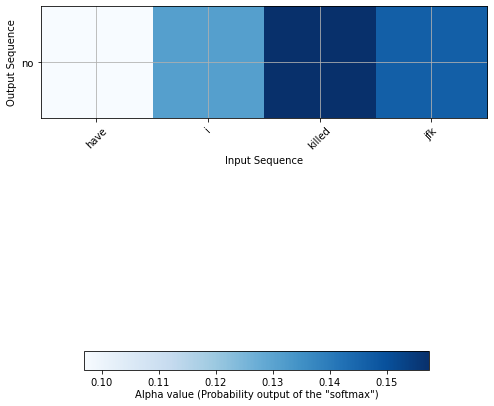

In [45]:

plot_attention_map(model, human_vocab, inv_machine_vocab, 
                   'have i killed jfk', n_s = n_s, num = 7, Tx = 10, Ty = 1)



array([[0.04866058, 0.06765182, 0.08122128, 0.11748584]])

<Figure size 432x288 with 0 Axes>

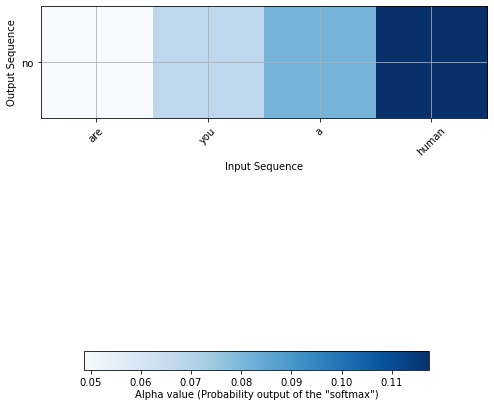

In [46]:

plot_attention_map(model, human_vocab, inv_machine_vocab, 
                   'are you a human', n_s = n_s, num = 7, Tx = 10, Ty = 1)


array([[0.01178811, 0.02059012, 0.04191503, 0.06605906, 0.0806603 ,
        0.11342463, 0.12503286, 0.16745412, 0.19771552, 0.17536031]])

<Figure size 432x288 with 0 Axes>

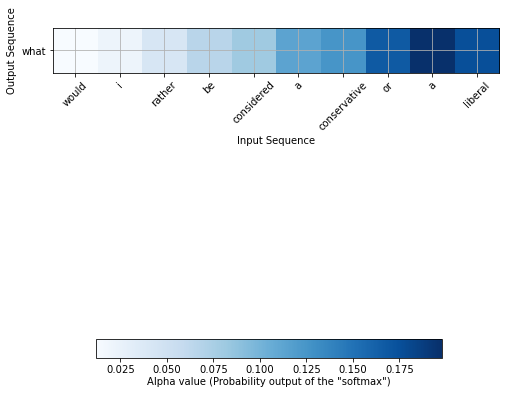

In [48]:

plot_attention_map(model, human_vocab, inv_machine_vocab, 
                   'would i rather be considered a conservative or a liberal', n_s = n_s, num = 7, Tx = 10, Ty = 1)
